---
# Trabalho 1 - Tópicos Especiais em Matemática Aplicada

**Alunos/Matricula:** João V. Farias & Renan V. Guedes / 221022604 & 221031363

**Arquitetura Usada:** Encoder-Decoder

**Dataset Link:** V1: [D-Talk](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatefr_to_pt) from TensorFlow.Datasets

---

### **Projeto para traduzir mensagens do Francês para o Portugues**  

Neste projeto, vamos explorar e comparar três arquiteturas de redes neurais para tradução automática do francês para o português, usando o *dataset* TED Talks do *Open Translation Project*. A ideia é testar modelos do tipo **Encoder-Decoder**, analisando suas diferenças e impacto na qualidade da tradução.  

Os três modelos que vamos treinar são:  

1. **LSTM (Long Short-Term Memory)**  
   - Um modelo básico de rede recorrente bidirecional. O **Encoder** processa a frase em francês e gera um contexto, enquanto o **Decoder** usa esse contexto para formar a tradução em português.  
   - A principal vantagem desse modelo é sua capacidade de lidar com dependências de longo prazo nas sequências.  

2. **LSTM com Mecanismos de Atenção**  
   - Uma versão aprimorada do modelo anterior, adicionando camadas de atenção (produto escalar, Bahdanau e Luong).  
   - A atenção ajuda o modelo a "olhar" para partes específicas da frase de entrada enquanto traduz, melhorando a coerência e precisão.  

3. **Transformers**  
   - Uma abordagem mais moderna, baseada em **autoatenção**, eliminando o uso de redes recorrentes.  
   - Trabalha com processamento paralelo, usando *Multi-Head Attention* e *Positional Encoding* para entender relações entre palavras, mesmo quando estão distantes na frase.  

**Como vamos testar os modelos?**  
- **Dataset**: Vamos usar cerca de 52.000 pares de frases (francês-português) para treinar, além de 1.200 para validação e 1.800 para teste.  
- **Pré-processamento**: Faremos a tokenização com *SubwordTextEncoder* para reduzir palavras fora do vocabulário (*out-of-vocabulary* – OOV).  
- **Treinamento**: Otimização com Adam, acompanhando a perda (*loss*) e a acurácia durante o processo.  
- **Avaliação**: Vamos comparar os resultados usando a métrica BLEU e analisar exemplos práticos das traduções.  

**O que esperamos encontrar?**  
- Nosso objetivo é entender qual desses modelos tem o melhor equilíbrio entre qualidade de tradução e eficiência computacional.  
- É provável que os Transformers tenham um desempenho superior, já que conseguem processar frases de forma mais eficiente, enquanto os modelos com LSTM e atenção devem mostrar um avanço significativo sobre a versão básica de LSTM.  

No fim das contas, essa análise pode ajudar a compreender melhor como diferentes abordagens de deep learning se saem em tarefas de tradução, trazendo insights úteis para aplicações reais em NLP.

---

## 📚 Importando as bibliotecas necessárias

In [16]:
# Primeiro, vamos importar todas as bibliotecas que vamos precisar ao longo do Projeto
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# Para processamento de texto
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Componentes do Keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, MultiHeadAttention
from tensorflow.keras.optimizers import Adam

# Para visualização dos resultados
from sklearn.metrics import confusion_matrix

tf.config.optimizer.set_jit(True)  # Ativa o XLA JIT compilation
tf.keras.mixed_precision.set_global_policy('mixed_float16') # Força o TensorFlow a usar precisão mista

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


## 🔍 Carregando e Preparando os Dados

In [3]:
#Agora vamos carregar nosso dataset de tradução
examples, metadata = tfds.load('ted_hrlr_translate/fr_to_pt', with_info=True,
                             as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

# Função para preprocessar o texto
def preprocess_text(text):
    # Adiciona espaços entre pontuação
    text = tf.strings.regex_replace(text, r"([?.!,¿])", r" \1 ")
    # Remove caracteres especiais
    text = tf.strings.regex_replace(text, r'[" "]+', " ")
    # Remove espaços extras
    text = tf.strings.strip(text)
    # Adiciona tokens de início e fim
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

# Vamos processar nossos dados
def prepare_dataset(pt, fr):
    pt = preprocess_text(pt)
    fr = preprocess_text(fr)
    return pt, fr

# Aplicando o preprocessamento
train_dataset = train_examples.map(prepare_dataset)
val_dataset = val_examples.map(prepare_dataset)

print("\n Dataset carregado e preprocessado com sucesso! 🎉")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/43873 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/fr_to_pt/incomplete.1PYMA9_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...:   0%|          | 0/1131 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/fr_to_pt/incomplete.1PYMA9_1.0.0/ted_hrlr_translate-val…

Generating test examples...:   0%|          | 0/1494 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/fr_to_pt/incomplete.1PYMA9_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/fr_to_pt/1.0.0. Subsequent calls will reuse this data.

 Dataset carregado e preprocessado com sucesso! 🎉


## 🛠️ Configurando os Tokenizers

In [4]:
# 🛠️ Configurando os Tokenizers (versão otimizada)
MAX_SAMPLES = 50000  # Limite de amostras para processamento mais rápido

# Coletando os textos para treinamento dos tokenizers
pt_texts = []
fr_texts = []
for pt, fr in train_dataset.take(MAX_SAMPLES):
    pt_texts.append(pt.numpy().decode('utf-8'))
    fr_texts.append(fr.numpy().decode('utf-8'))

# Criando e treinando os tokenizers de uma vez
tokenizer_pt = Tokenizer(filters='')
tokenizer_fr = Tokenizer(filters='')

# Treinamento em batch
tokenizer_pt.fit_on_texts(pt_texts)
tokenizer_fr.fit_on_texts(fr_texts)

print("Vocabulário em Português:", len(tokenizer_pt.word_index))
print("Vocabulário em Francês:", len(tokenizer_fr.word_index))

Vocabulário em Português: 36969
Vocabulário em Francês: 37511


# 🤖 Modelo 1: LSTM Básico
### Vamos começar com o modelo mais simples: um **Encoder-Decoder** usando **LSTM**

## 1️⃣ Configurando os Hiperparâmetros

In [8]:
# Estes valores foram escolhidos com base em experimentos de tradução encontrados na internet
EMBEDDING_DIM = 256  # Dimensão dos embeddings
LSTM_UNITS = 512    # Número de unidades LSTM
BATCH_SIZE = 64     # Tamanho do batch
EPOCHS = 10         # Número de épocas para treinar

## 2️⃣ Preparando os Dados para o Modelo

In [11]:
# Vamos converter nossos textos em sequências numéricas
def prepare_data(pt_texts, fr_texts, max_length=40):
    # Convertendo textos para sequências
    pt_sequences = tokenizer_pt.texts_to_sequences(pt_texts)
    fr_sequences = tokenizer_fr.texts_to_sequences(fr_texts)

    # Padding das sequências
    pt_padded = pad_sequences(pt_sequences, maxlen=max_length, padding='post')
    fr_padded = pad_sequences(fr_sequences, maxlen=max_length, padding='post')

    return pt_padded, fr_padded

# Preparando os dados de treino
pt_train = []
fr_train = []
for pt, fr in train_dataset.take(MAX_SAMPLES):
    pt_train.append(pt.numpy().decode('utf-8'))
    fr_train.append(fr.numpy().decode('utf-8'))

X_train, y_train = prepare_data(pt_train, fr_train)

## 3️⃣ Construindo o Modelo LSTM

In [12]:
def build_lstm_model(vocab_size_pt, vocab_size_fr):
    # Encoder
    encoder_inputs = Input(shape=(None,))
    enc_emb = Embedding(vocab_size_pt, EMBEDDING_DIM)(encoder_inputs)
    encoder_lstm = LSTM(LSTM_UNITS, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    dec_emb = Embedding(vocab_size_fr, EMBEDDING_DIM)(decoder_inputs)
    decoder_lstm = LSTM(LSTM_UNITS, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
    decoder_dense = Dense(vocab_size_fr, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Modelo completo
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

## 4️⃣ Criando e Compilando o Modelo

In [13]:
vocab_size_pt = len(tokenizer_pt.word_index) + 1
vocab_size_fr = len(tokenizer_fr.word_index) + 1

model = build_lstm_model(vocab_size_pt, vocab_size_fr)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrando um resumo do modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │      9,464,320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │      9,603,072 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 512), (None,   │      1,574,912 │ embedding[0][0]        │
│                           │ 512), (None, 512)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 512),    │      1,574,912 │ embedding_1[0][0],     │
│                           │ (None, 512), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 37512)    │     19,243,656 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 41,460,872 (158.16 MB)

 Trainable params: 41,460,872 (158.16 MB)

 Non-trainable params: 0 (0.00 B)

## 5️⃣ Treinando o Modelo

In [14]:
# Preparando os dados do decoder (deslocados em uma posição)
decoder_input_data = y_train[:, :-1]
decoder_target_data = y_train[:, 1:]

# Treinamento
history = model.fit(
    [X_train, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5600 - loss: 3.9299 - val_accuracy: 0.6409 - val_loss: 2.5682
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.6401 - loss: 2.5261 - val_accuracy: 0.6539 - val_loss: 2.3996
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6544 - loss: 2.3222 - val_accuracy: 0.6552 - val_loss: 2.3233
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6632 - loss: 2.1871 - val_accuracy: 0.6637 - val_loss: 2.2422
Epoch 5/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6717 - loss: 2.0505 - val_accuracy: 0.6660 - val_loss: 2.2134
Epoch 6/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6753 - loss: 1.9489 - val_accuracy: 0.6682 - val_loss: 2.1985
Epoch 7/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6811 - loss: 1.8424 - val_accuracy: 0.6689 - val_loss: 2.1974
Epoch 8/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6883 - loss: 1.7340 - 

## 6️⃣ Visualizando os Resultados

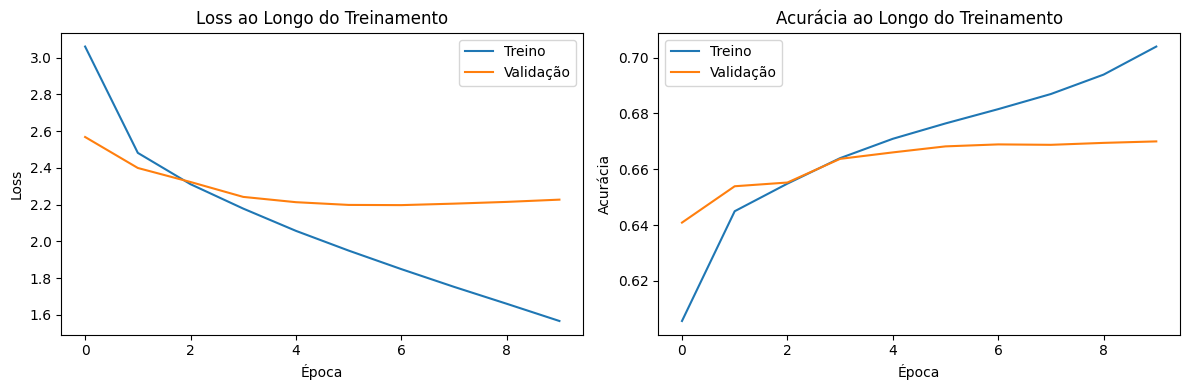

In [15]:
plt.figure(figsize=(12, 4))

# Plot da loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss ao Longo do Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Plot da acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia ao Longo do Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()